In [5]:
from psychopy import visual, event, core
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [6]:
# Letter Stimulus 
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()

def LetterImage(letter, image_size = 128, letter_size = 64, bg_color = 0, letter_color = 1):
    image = Image.new('L', (image_size, image_size), color=bg_color)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", letter_size)
    bbox = draw.textbbox((0, 0), letter, font = font)
    letter_w, letter_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    image_w, image_h = image.size
    x = (image_w - letter_w) // 2 - bbox[0]
    y = (image_h - letter_h) // 2 - bbox[1]
    draw.text((x, y), letter, font = font, fill=letter_color)
    return np.array(image).astype(np.float32)

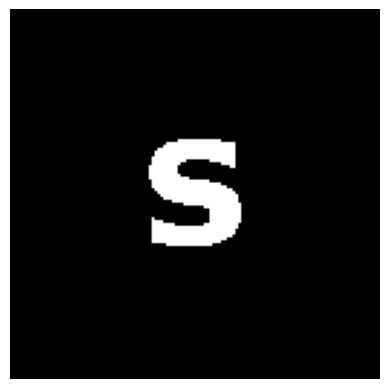

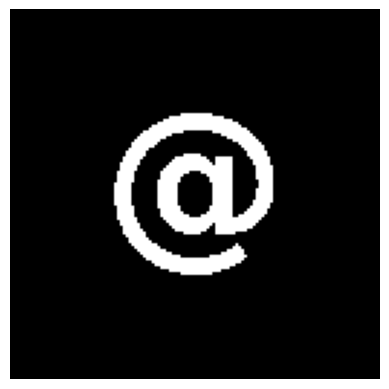

In [7]:
ShowImage(LetterImage(letter = 's'))
ShowImage(LetterImage(letter = '@'))

Experiment aborted by user.
Experiment aborted by user.
11.9032 	WARNING 	Monitor specification not found. Creating a temporary one...
11.9782 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [3440, 1440]. Using actual size


ValueError: x and y must have same first dimension, but have shapes (50,) and (9,)

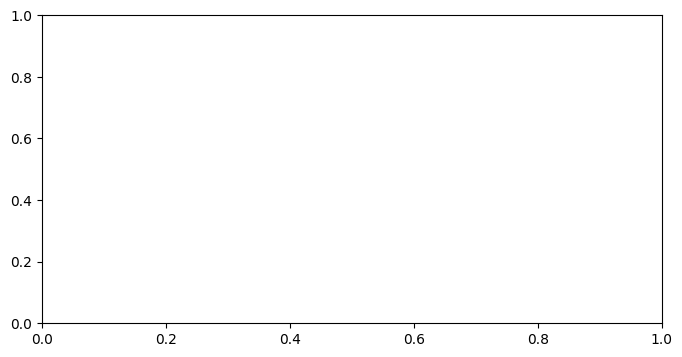

In [11]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(1920, 1080), color=-1, units="pix", fullscr=True)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
letters = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
noises = ['#', '@', '$', '%', '&']
soa = 0.1
soa_practice = [0.1, 0.15, 0.2]
noise_gap = 0.05
step_size = 0.005
n_trials = 50
n_practices = 10
correct_counter = 0
data = []

# Welcome Screen
text = visual.TextStim(win, text="Welcome to the experiment! Press SPACE to begin the instruction", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Instruction Screen
text = visual.TextStim(win, text="In this experiment, you will see a letter embedded in noise. The letter will be chosen from the second row of the keyboard - [A,S,D,F,G,H,J,K,L]\
                                        The below one is a letter A.\
                                        \n\n The letter be briefly flashed and then immediately masked by some other symbols, your task is to choose the letter you see using the second row of the keyboard.\
                                        \n\n Press SPACE to continue", color=1.0, height=24, pos = (0, 300))
text.draw()
image = visual.ImageStim(image = np.flipud(Norm(LetterImage(letter = 'A'))), win = win, size=(512, 512), pos = (0, -200), units="pix")
image.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Practice trail screen
text = visual.TextStim(win, text="We will begin with several practice trials, feedback on correctness will be provided after each trial.\
                                \n\n Choose the letter using the second row of the keyboard.\
                                \n\n Press SPACE to start the practice trials. ", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Trial Loop
for trial in range(n_practices):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    # Fixation
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    # Stimulus
    letter, practice_soa = random.choice(letters), random.choice(soa_practice)
    stim.image = np.flipud(Norm(LetterImage(letter)))
    stim.draw()
    win.flip()
    core.wait(practice_soa)
    for i in range(3):
        noise = random.choice(noises)
        stim.image = np.flipud(Norm(LetterImage(noise)))
        stim.draw()
        win.flip()
        core.wait(noise_gap)
        
    # Decision
    wait = visual.TextStim(win, text="Choose the letter", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['a', 's', 'd','f','g','h','j','k','l','escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break
    win.flip()


    response = keys[0].upper()
    correct = response == letter

    # Feedback 
    if correct:
        feedback_text = "Correct!"
        feedback_color = 'green'
    else:
        feedback_text = f"Wrong! The correct letter was: {letter}"
        feedback_color = 'red'
    
    feedback = visual.TextStim(win, text=feedback_text, color=feedback_color, height=36)
    feedback.draw()
    win.flip()
    core.wait(0.5)  
    win.flip()
    core.wait(0.5)


# --- Main Staircase Block ---
text = visual.TextStim(win, text="Excellent! Here comes the main experiment. This time the task is more difficult, please pay attention\
                                \n\n Choose the letter using the second row of the keyboard.\
                                \n\n Press SPACE to start the main experiment. ", color=1.0, height=24)

text.draw()
win.flip()
event.waitKeys(keyList=['space'])

for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)
    letter = random.choice(letters)
    stim.image = np.flipud(Norm(LetterImage(letter)))
    stim.draw()
    win.flip()
    core.wait(soa)
    for i in range(3):
        noise = random.choice(noises)
        stim.image = np.flipud(Norm(LetterImage(noise)))
        stim.draw()
        win.flip()
        core.wait(noise_gap)
        
    win.flip()
    
    keys = event.waitKeys(keyList=[l.lower() for l in letters] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = keys[0].upper()
    correct = response == true_letter
    data.append({"trial": trial+1, "letter": letter, "response": response,
                 "correct": correct, "soa": soa})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            soa = max(0, soa - step_size)
            correct_counter = 0
    else:
        soa = min(1.0, soa + step_size)
        correct_counter = 0
    core.wait(0.5)

# Cleanup 
win.close()

# ---------- Plot ----------
soas = [d["soa"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), soas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)